# 1. Limpieza de Datos:
Identificación y eliminación de valores duplicados: Asegúrate de que no haya registros duplicados que puedan sesgar los resultados del análisis.
Verificación y ajuste de tipos de datos: Verifica que cada columna tenga el tipo de dato correcto (numérico o categórico) y ajusta si es necesario.
Corrección de inconsistencias en valores categóricos: Revisa las categorías de las variables y unifica aquellos valores que puedan estar escritos de diferentes maneras pero que representen lo mismo.
Manejo de valores faltantes adecuadamente: Identifica y maneja los valores faltantes utilizando técnicas apropiadas como la imputación de la mediana, media o moda, según corresponda.

In [20]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import lazypredict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier

# 1. Cargar el dataset
df = pd.read_csv('../Data/diabetes.csv')  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head(10).T



,0,1,2,3,4,5,6,7,8,9
Pregnancies,6.00,1.00,8.00,1.00,0.00,5.00,3.00,10.00,2.00,8.00
Glucose,148.00,85.00,183.00,89.00,137.00,116.00,78.00,115.00,197.00,125.00
BloodPressure,72.00,66.00,64.00,66.00,40.00,74.00,50.00,0.00,70.00,96.00
SkinThickness,35.00,29.00,0.00,23.00,35.00,0.00,32.00,0.00,45.00,0.00
Insulin,0.00,0.00,0.00,94.00,168.00,0.00,88.00,0.00,543.00,0.00
BMI,33.60,26.60,23.30,28.10,43.10,25.60,31.00,35.30,30.50,0.00
DiabetesPedigreeFunction,0.63,0.35,0.67,0.17,2.29,0.20,0.25,0.13,0.16,0.23
Age,50.00,31.00,32.00,21.00,33.00,30.00,26.00,29.00,53.00,54.00
Outcome,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00


In [21]:
# Limpieza de datos
# a. Identificar y eliminar duplicados
print(f'Duplicados: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)

# b. Verificar tipos de datos
print(df.info())

Duplicados: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Pregnancies                768 non-null    int64  
 1   Glucose                    768 non-null    int64  
 2   BloodPressure              768 non-null    int64  
 3   SkinThickness              768 non-null    int64  
 4   Insulin                    768 non-null    int64  
 5   BMI                        768 non-null    float64
 6   DiabetesPedigreeFunction   768 non-null    float64
 7   Age                        768 non-null    int64  
 8   Outcome                    768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [22]:
# Verificar las columnas
print(df.columns)

# Eliminar espacios adicionales en los nombres de las columnas (si existen)
df.columns = df.columns.str.strip()

# Reemplazar ceros inapropiados en las columnas clave con NaN
cols_with_missing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Verificar si todas las columnas están presentes
for col in cols_with_missing:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)
    else:
        print(f"Columna {col} no encontrada.")

# Imputar valores faltantes con la mediana
for col in cols_with_missing:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Verificar valores faltantes después de la imputación
print(f'Valores faltantes tras imputación:\n{df.isnull().sum()}')


Index(['Pregnancies ', 'Glucose ', 'BloodPressure ', 'SkinThickness ',
       'Insulin ', 'BMI  ', 'DiabetesPedigreeFunction ', 'Age ', 'Outcome'],
      dtype='object')
Valores faltantes tras imputación:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [23]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Pregnancies,6.00,1.00,8.00,1.00,0.00,5.00,3.00,10.00,2.00,8.00
Glucose,148.00,85.00,183.00,89.00,137.00,116.00,78.00,115.00,197.00,125.00
BloodPressure,72.00,66.00,64.00,66.00,40.00,74.00,50.00,72.00,70.00,96.00
SkinThickness,35.00,29.00,29.00,23.00,35.00,29.00,32.00,29.00,45.00,29.00
Insulin,125.00,125.00,125.00,94.00,168.00,125.00,88.00,125.00,543.00,125.00
BMI,33.60,26.60,23.30,28.10,43.10,25.60,31.00,35.30,30.50,32.30
DiabetesPedigreeFunction,0.63,0.35,0.67,0.17,2.29,0.20,0.25,0.13,0.16,0.23
Age,50.00,31.00,32.00,21.00,33.00,30.00,26.00,29.00,53.00,54.00
Outcome,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,1.00


# 2. Exploración de Datos:
Visualizaciones univariadas y multivariadas: Crea histogramas, gráficos de barras, diagramas de dispersión y mapas de calor para entender la distribución y las relaciones entre las variables.
Estadísticas descriptivas: Calcula medidas de tendencia central (media, mediana, moda) y de dispersión (rango, desviación estándar) para cada característica del dataset.


In [24]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df.describe())


Estadísticas descriptivas:
       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
count       768.00   768.00         768.00         768.00   768.00 768.00   
mean          3.85   121.66          72.39          29.11   140.67  32.46   
std           3.37    30.44          12.10           8.79    86.38   6.88   
min           0.00    44.00          24.00           7.00    14.00  18.20   
25%           1.00    99.75          64.00          25.00   121.50  27.50   
50%           3.00   117.00          72.00          29.00   125.00  32.30   
75%           6.00   140.25          80.00          32.00   127.25  36.60   
max          17.00   199.00         122.00          99.00   846.00  67.10   

       DiabetesPedigreeFunction    Age  Outcome  
count                    768.00 768.00   768.00  
mean                       0.47  33.24     0.35  
std                        0.33  11.76     0.48  
min                        0.08  21.00     0.00  
25%                        0

In [25]:
# Medidas de tendencia central (media, mediana, moda) y dispersión
for col in df.columns:
    print(f"\n{col} - Media: {df[col].mean()}, Mediana: {df[col].median()}, Moda: {df[col].mode()[0]}")
    print(f"Rango: {df[col].max() - df[col].min()}, Desviación estándar: {df[col].std()}")


Pregnancies - Media: 3.8450520833333335, Mediana: 3.0, Moda: 1
Rango: 17, Desviación estándar: 3.3695780626988623

Glucose - Media: 121.65625, Mediana: 117.0, Moda: 99.0
Rango: 155.0, Desviación estándar: 30.43828582241517

BloodPressure - Media: 72.38671875, Mediana: 72.0, Moda: 72.0
Rango: 98.0, Desviación estándar: 12.096641733978139

SkinThickness - Media: 29.108072916666668, Mediana: 29.0, Moda: 29.0
Rango: 92.0, Desviación estándar: 8.791221023089737

Insulin - Media: 140.671875, Mediana: 125.0, Moda: 125.0
Rango: 832.0, Desviación estándar: 86.383059693181

BMI - Media: 32.45520833333333, Mediana: 32.3, Moda: 32.3
Rango: 48.89999999999999, Desviación estándar: 6.875176818080996

DiabetesPedigreeFunction - Media: 0.47187630208333325, Mediana: 0.3725, Moda: 0.254
Rango: 2.342, Desviación estándar: 0.33132859501277484

Age - Media: 33.240885416666664, Mediana: 29.0, Moda: 22
Rango: 60, Desviación estándar: 11.76023154067868

Outcome - Media: 0.3489583333333333, Mediana: 0.0, Moda:

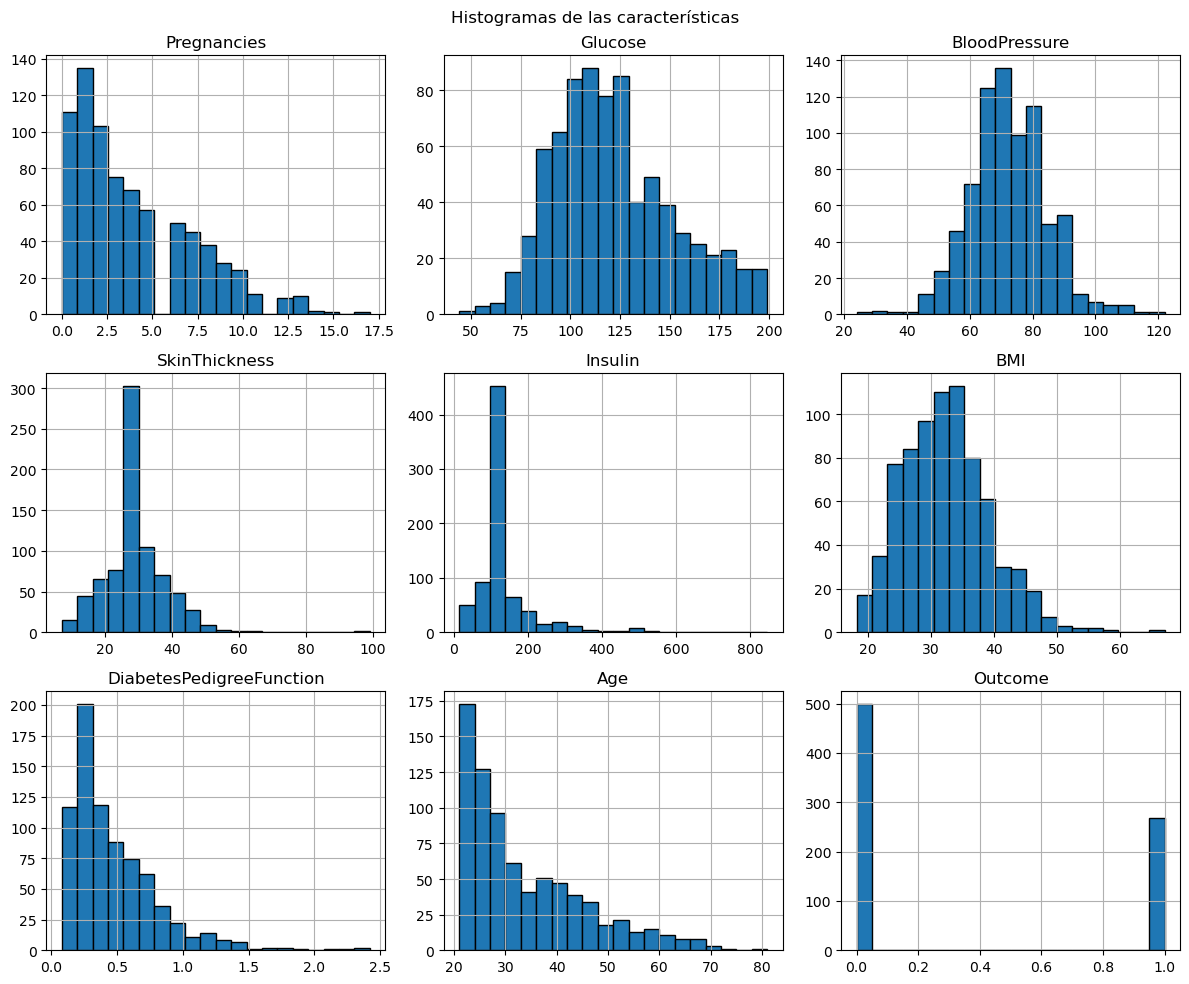

In [26]:
# 1. Histogramas para cada columna numérica
df.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Histogramas de las características')
plt.tight_layout()
plt.show()

Pregnancies: La distribución de embarazos es sesgada hacia valores bajos, con la mayoría de los individuos teniendo entre 0 y 2 embarazos. Esto sugiere que la cantidad de embarazos no tiene una gran variabilidad en este conjunto de datos.

Glucose: La distribución de glucosa muestra una forma sesgada hacia la derecha, con un pico alrededor de 100. Hay pocos casos con niveles extremadamente altos de glucosa, lo que podría indicar que la mayoría de las personas tiene niveles moderados de glucosa en sangre.

BloodPressure: Los niveles de presión arterial están distribuidos de forma relativamente normal, con el mayor número de individuos teniendo entre 60 y 80 de presión arterial. No se observan valores muy extremos en esta variable.

SkinThickness: La distribución de grosor de la piel es altamente sesgada hacia la izquierda, con la mayoría de los individuos teniendo valores bajos, especialmente alrededor de 20. Esto podría indicar que la variable tiene muchos valores de cero o cercanos a cero, lo que puede ser un indicio de que ciertos valores de la variable no están siendo reportados o registrados correctamente.

Insulin: La distribución de los niveles de insulina también muestra un sesgo hacia la izquierda, con una gran cantidad de individuos con valores cercanos a cero. Esto podría sugerir que en la mayoría de los casos no se reportan altos niveles de insulina, o que los valores elevados son poco frecuentes.

BMI (Índice de masa corporal): La distribución del BMI es bastante simétrica, con la mayoría de los individuos teniendo un índice de masa corporal entre 20 y 35. Hay algunos casos con valores más bajos y otros con valores más altos, pero la mayor concentración está en el rango intermedio.

DiabetesPedigreeFunction: La distribución de la función genética relacionada con la diabetes muestra un sesgo hacia la izquierda, con la mayoría de los individuos teniendo valores cercanos a 0, lo que indica que pocos individuos tienen antecedentes familiares fuertes de diabetes.

Age (Edad): La distribución de la edad muestra una forma más uniforme, con una concentración de personas jóvenes (alrededor de los 20 años), pero con algunos casos en todos los rangos de edad, hasta los 80 años.

Outcome (Resultado): La variable Outcome, que indica la presencia o ausencia de diabetes, muestra una distribución muy desbalanceada, con la mayoría de los individuos en el grupo sin diabetes, y solo una pequeña fracción de ellos con diabetes. Esto refleja un desbalance típico en los conjuntos de datos médicos, donde las personas sin la condición son más numerosas.

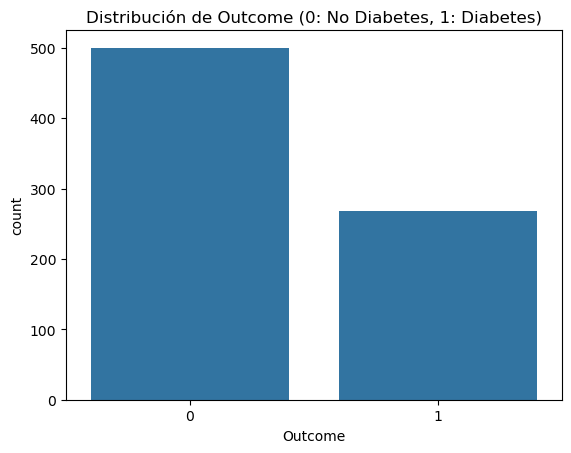

In [27]:
# 2. Gráficos de barras para columnas categóricas (en este caso, la variable 'Outcome')
sns.countplot(x='Outcome', data=df)
plt.title('Distribución de Outcome (0: No Diabetes, 1: Diabetes)')
plt.show()

Hay un mayor numero de mujeres sin diabetes que con diabetes mostrando asi una distribucion desbalanceada.

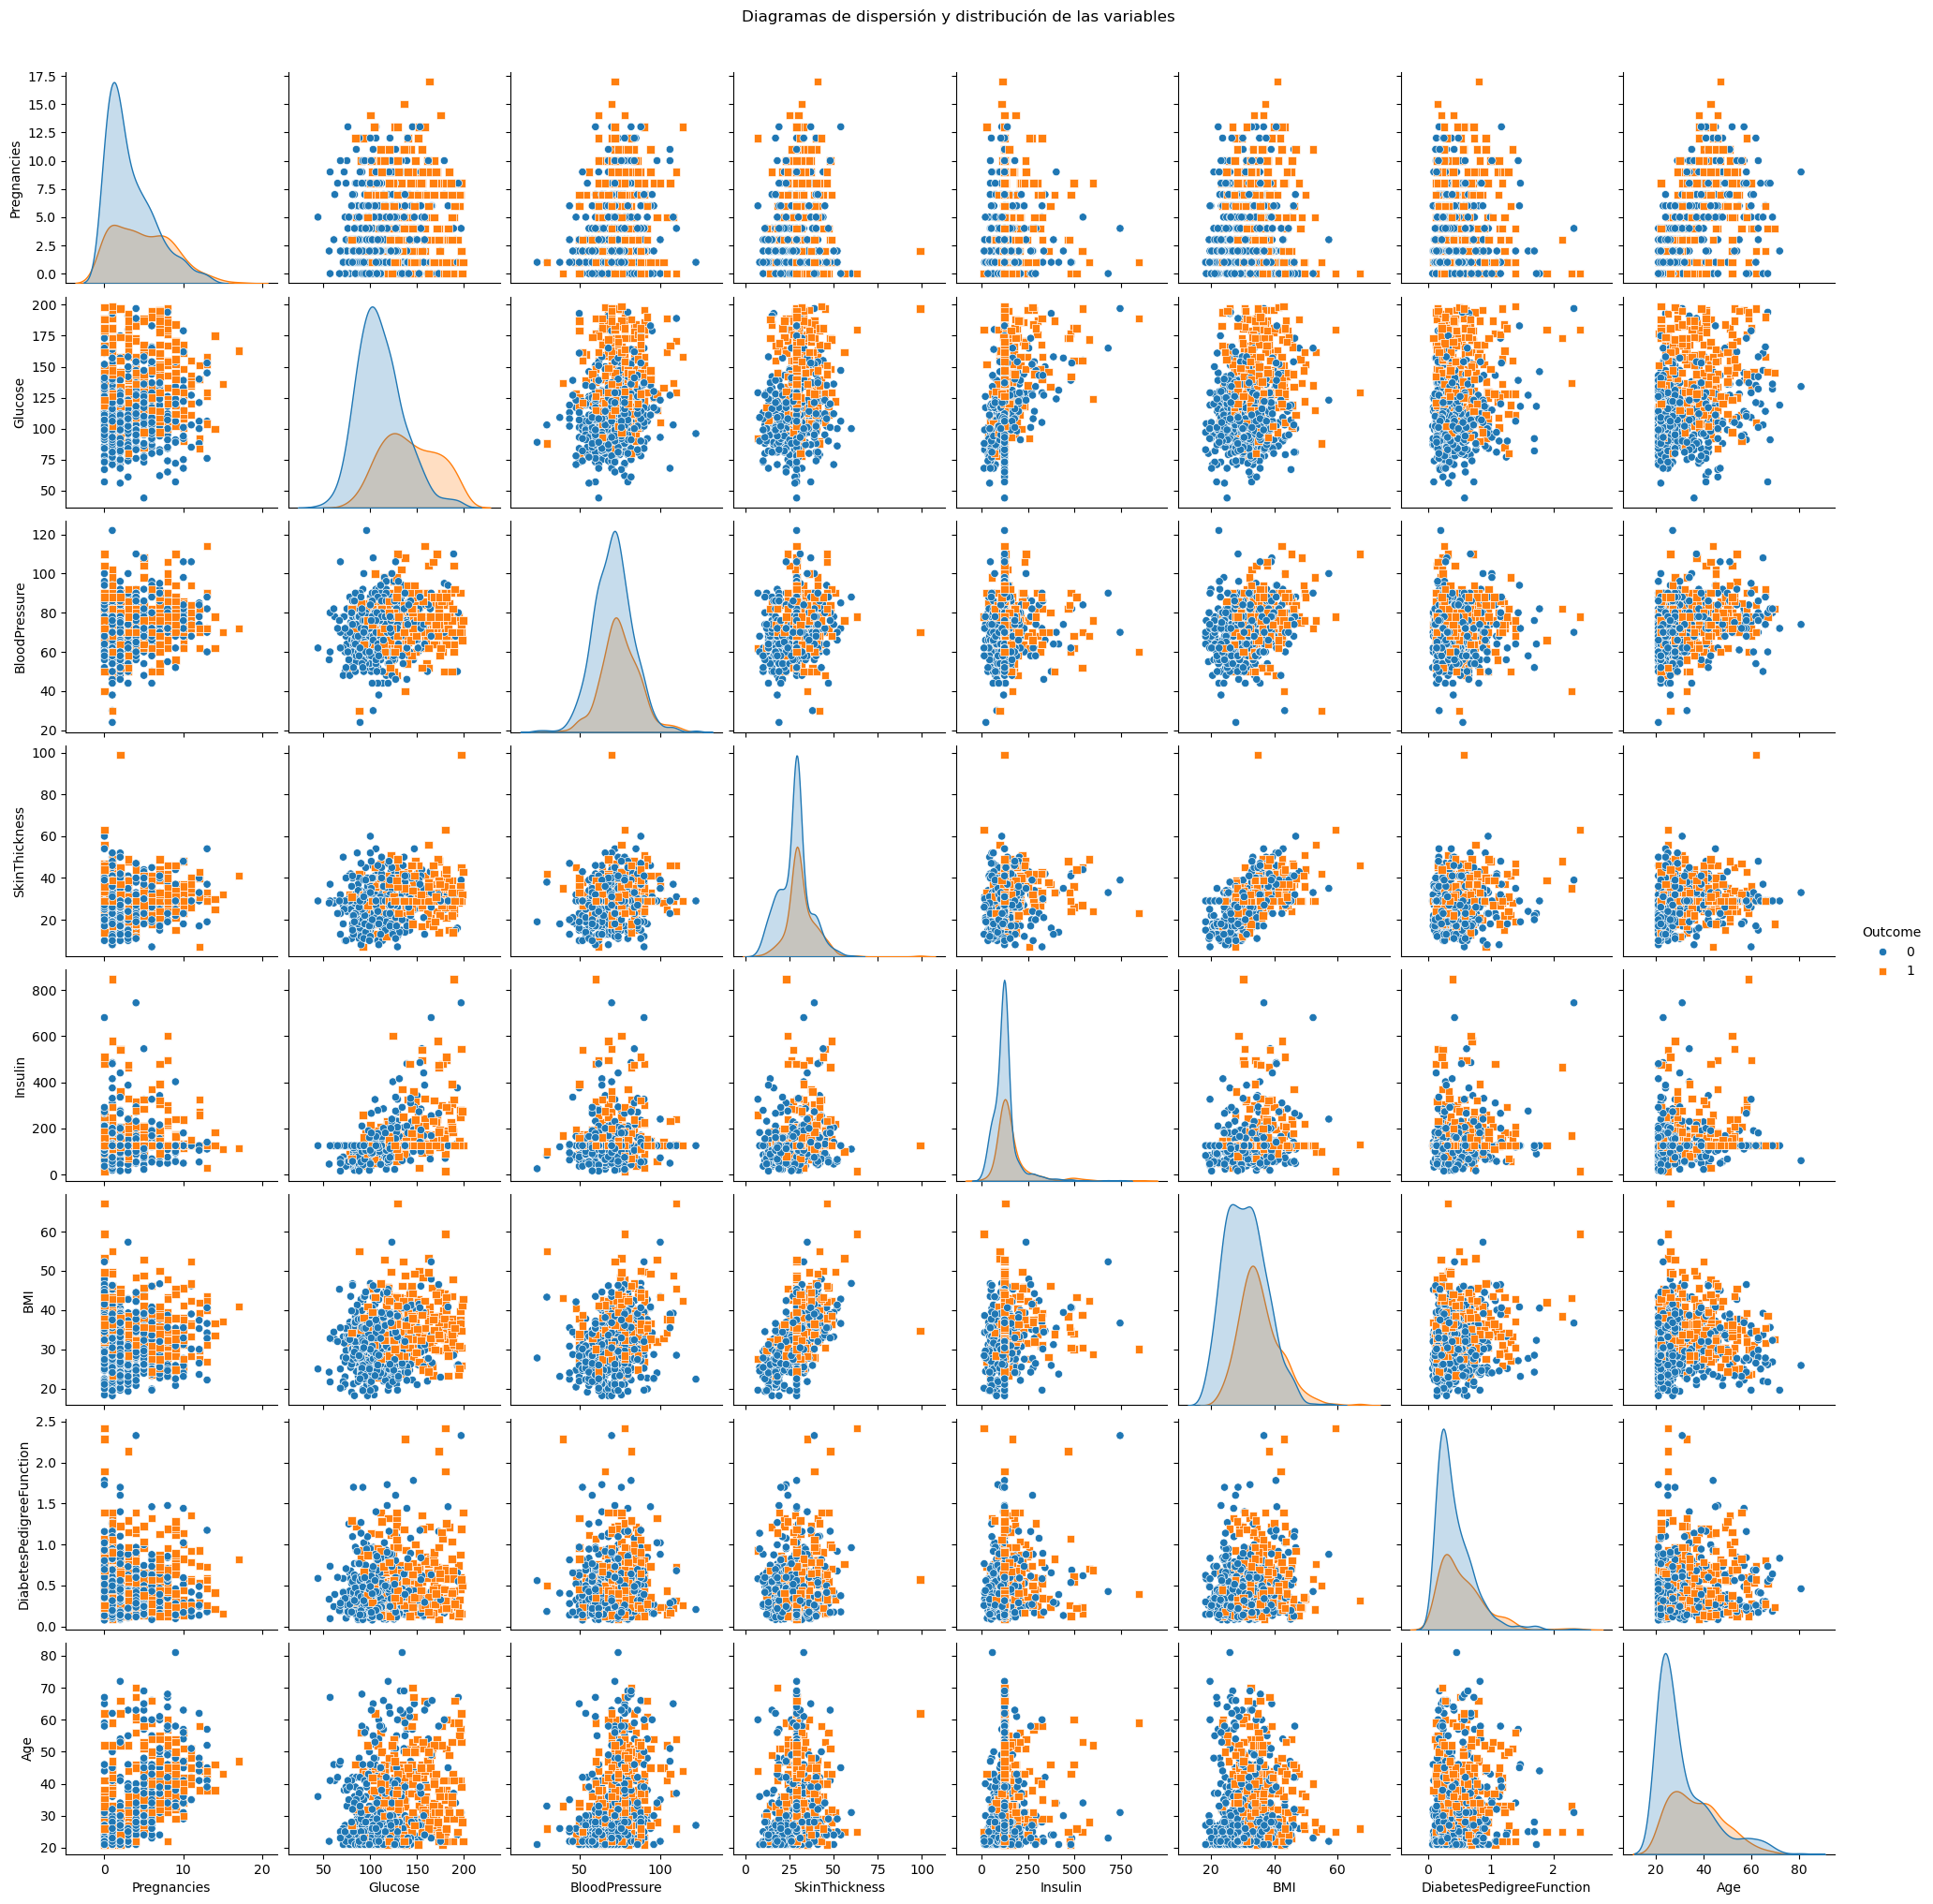

In [28]:
# 3. Diagramas de dispersión entre las variables clave
sns.pairplot(df, hue='Outcome', diag_kind='kde', markers=["o", "s"])
plt.suptitle('Diagramas de dispersión y distribución de las variables', y=1.02)
plt.show()

En resumen, las variables Glucose y BMI son las que muestran una relación más clara con el Outcome, mientras que otras como BloodPressure, SkinThickness, y DiabetesPedigreeFunction no presentan relaciones tan fuertes con el diagnóstico de diabetes. Esto sugiere que los niveles de glucosa y el índice de masa corporal son factores clave en la predicción de la diabetes en este conjunto de datos.

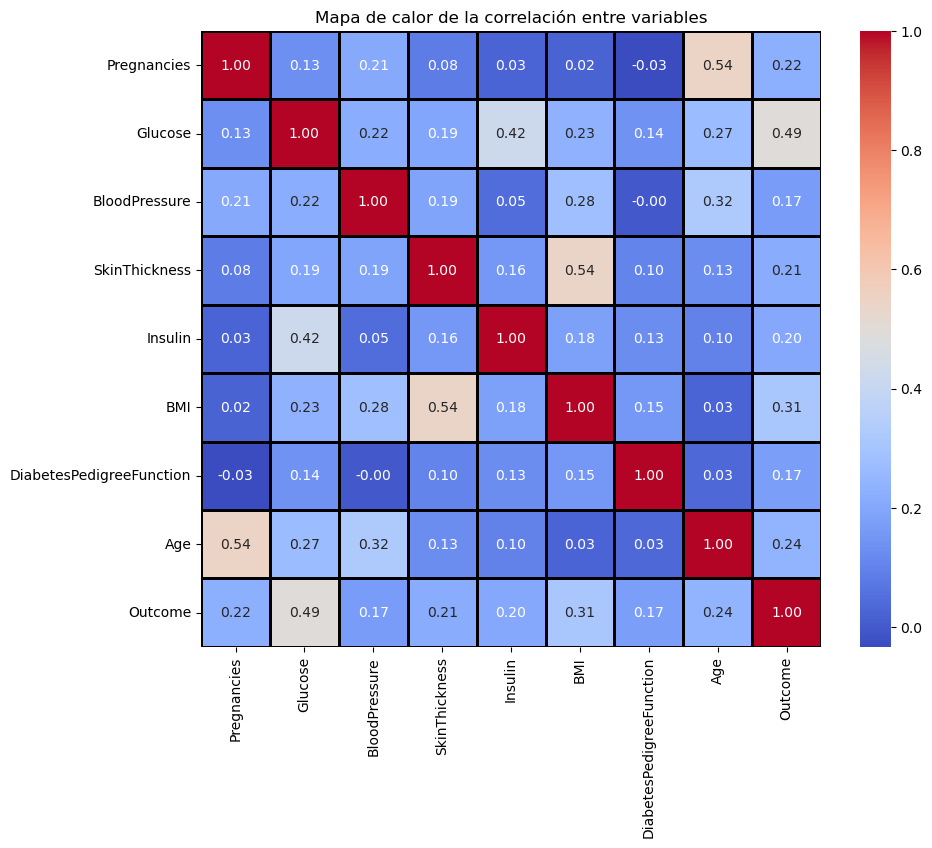

In [29]:
# 4. Mapa de calor de correlación entre las variables
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, linecolor='black')
plt.title('Mapa de calor de la correlación entre variables')
plt.show()


En resumen, el mapa de calor revela las relaciones más significativas entre las variables, siendo las más destacadas la correlación entre glucosa e insulina con el resultado (presencia de diabetes). Las variables como edad y embarazos también muestran algunas asociaciones relevantes, mientras que otras como la presión arterial y el pedigrí de diabetes tienen correlaciones más débiles.

# 3. Implementación de Modelos:
Modelos de Clasificación: Implementa modelos de Random Forest y XGBoost.
Evaluación de Modelos: Evalúa los modelos utilizando métricas como accuracy, precision, recall, F1-score, y ROC-AUC.
Comparación de Rendimiento: Compara los resultados de ambos modelos y discute cuál es el más adecuado para este dataset.


In [30]:
# Preparar los datos para el modelado
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Cálculo de métricas para Random Forest
accuracy_rf = accuracy_score(y_test, rf_pred)
precision_rf = precision_score(y_test, rf_pred)
recall_rf = recall_score(y_test, rf_pred)
f1_rf = f1_score(y_test, rf_pred)
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print(f"Accuracy (Random Forest): {accuracy_rf}")
print(f"Precision (Random Forest): {precision_rf}")
print(f"Recall (Random Forest): {recall_rf}")
print(f"F1-Score (Random Forest): {f1_rf}")
print(f"ROC-AUC (Random Forest): {roc_auc_rf}\n")
# Modelo XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Cálculo de métricas para XGBoost
accuracy_xgb = accuracy_score(y_test, xgb_pred)
precision_xgb = precision_score(y_test, xgb_pred)
recall_xgb = recall_score(y_test, xgb_pred)
f1_xgb = f1_score(y_test, xgb_pred)
roc_auc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
print(f"Accuracy (XGBoost): {accuracy_xgb}")
print(f"Precision (XGBoost): {precision_xgb}")
print(f"Recall (XGBoost): {recall_xgb}")
print(f"F1-Score (XGBoost): {f1_xgb}")
print(f"ROC-AUC (XGBoost): {roc_auc_xgb}\n")
# LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print("LazyClassifier Results:")
print(models.head())  # Imprime las primeras filas del DataFrame para ver cómo está estructurado
print(models.columns)

# Extrae las métricas usando los nombres correctos de las columnas
roc_auc_lazy = models.loc[models.index == 'RandomForestClassifier', 'ROC AUC'].values[0]
accuracy_lazy = models.loc[models.index == 'RandomForestClassifier', 'Accuracy'].values[0]
f1_lazy = models.loc[models.index == 'RandomForestClassifier', 'F1 Score'].values[0]
# Imprime las métricas
print(f"Accuracy (LazyClassifier): {accuracy_lazy}")
print(f"F1-Score (LazyClassifier): {f1_lazy}")
print(f"ROC-AUC (LazyClassifier): {roc_auc_lazy}\n")

# Modelo LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

# Cálculo de métricas para LightGBM
accuracy_lgbm = accuracy_score(y_test, lgbm_pred)
precision_lgbm = precision_score(y_test, lgbm_pred)
recall_lgbm = recall_score(y_test, lgbm_pred)
f1_lgbm = f1_score(y_test, lgbm_pred)
roc_auc_lgbm = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])

print("LightGBM Classification Report:")
print(classification_report(y_test, lgbm_pred))
print(f"Accuracy (LightGBM): {accuracy_lgbm}")
print(f"Precision (LightGBM): {precision_lgbm}")
print(f"Recall (LightGBM): {recall_lgbm}")
print(f"F1-Score (LightGBM): {f1_lgbm}")
print(f"ROC-AUC (LightGBM): {roc_auc_lgbm}\n")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        99
           1       0.62      0.64      0.63        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154

Accuracy (Random Forest): 0.7337662337662337
Precision (Random Forest): 0.625
Recall (Random Forest): 0.6363636363636364
F1-Score (Random Forest): 0.6306306306306306
ROC-AUC (Random Forest): 0.8340679522497705

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        99
           1       0.59      0.67      0.63        55

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73      0.71      0.72       154

Accuracy (XGBoost): 0.7142857142857143
Precision (XGBoost): 0.58730

100%|██████████| 29/29 [00:04<00:00,  6.61it/s]

[LightGBM] [Info] Number of positive: 213, number of negative: 401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346906 -> initscore=-0.632669
[LightGBM] [Info] Start training from score -0.632669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [32]:
# Crear un diccionario con las métricas de los cuatro modelos
metrics = {
    'Model': ['Random Forest', 'XGBoost', 'LazyClassifier', 'LightGBM'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_lazy, accuracy_lgbm],
    'Precision': [precision_rf, precision_xgb, None, precision_lgbm],  # LazyClassifier no proporciona precisión directamente
    'Recall': [recall_rf, recall_xgb, None, recall_lgbm],  # LazyClassifier no proporciona recall directamente
    'F1-Score': [f1_rf, f1_xgb, f1_lazy, f1_lgbm],
    'ROC-AUC': [roc_auc_rf, roc_auc_xgb, roc_auc_lazy, roc_auc_lgbm]
}

# Crear un DataFrame para mostrar la comparación
df_comparison = pd.DataFrame(metrics)

# Reemplazar los valores NaN o None por 0
df_comparison = df_comparison.fillna(0)
# Mostrar el DataFrame con las métricas de comparación
print(df_comparison)

            Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0   Random Forest      0.73       0.62    0.64      0.63     0.83
1         XGBoost      0.71       0.59    0.67      0.63     0.78
2  LazyClassifier      0.73       0.00    0.00      0.73     0.71
3        LightGBM      0.72       0.60    0.67      0.63     0.78


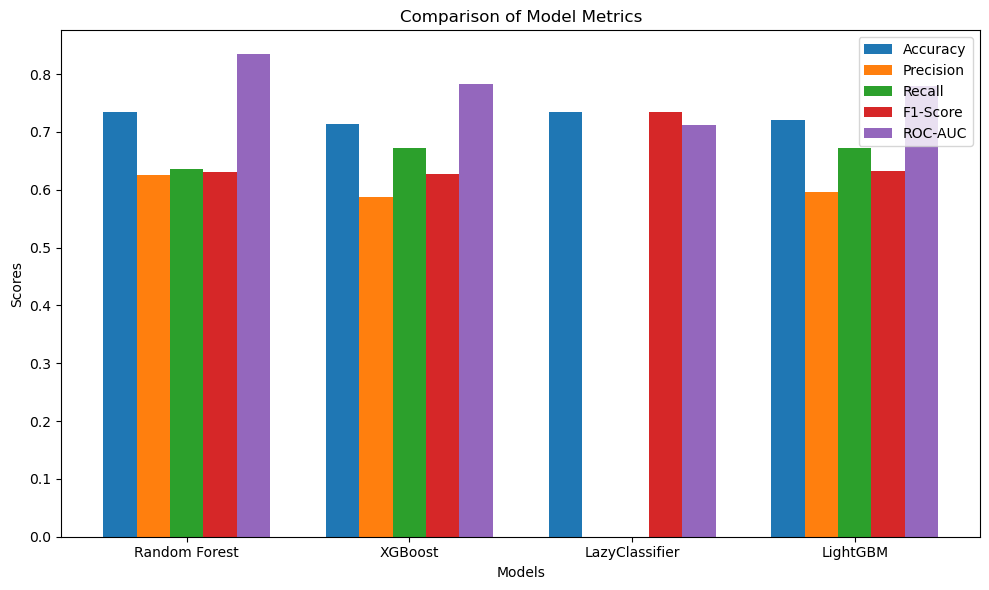

In [33]:
# Crear un diccionario con las métricas de los cuatro modelos 
metrics = {
    'Model': ['Random Forest', 'XGBoost', 'LazyClassifier', 'LightGBM'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_lazy, accuracy_lgbm],
    'Precision': [precision_rf, precision_xgb, 0, precision_lgbm],  # Reemplazar None por 0
    'Recall': [recall_rf, recall_xgb, 0, recall_lgbm],  # Reemplazar None por 0
    'F1-Score': [f1_rf, f1_xgb, f1_lazy, f1_lgbm],
    'ROC-AUC': [roc_auc_rf, roc_auc_xgb, roc_auc_lazy, roc_auc_lgbm]
}

# Crear un DataFrame para mostrar la comparación
df_comparison = pd.DataFrame(metrics)

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Establecer el ancho de las barras
bar_width = 0.15

# Crear las posiciones para las barras
index = range(len(df_comparison))

# Crear las barras para cada métrica
bar_accuracy = ax.bar([i - 2*bar_width for i in index], df_comparison['Accuracy'], bar_width, label='Accuracy')
bar_precision = ax.bar([i - bar_width for i in index], df_comparison['Precision'], bar_width, label='Precision')
bar_recall = ax.bar(index, df_comparison['Recall'], bar_width, label='Recall')
bar_f1 = ax.bar([i + bar_width for i in index], df_comparison['F1-Score'], bar_width, label='F1-Score')
bar_roc_auc = ax.bar([i + 2*bar_width for i in index], df_comparison['ROC-AUC'], bar_width, label='ROC-AUC')

# Añadir etiquetas y título
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Metrics')
ax.set_xticks(index)
ax.set_xticklabels(df_comparison['Model'])
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Este gráfico proporciona una comparación rápida de cómo se desempeñan las metricas de los modelos, donde el valor más alto indica un mejor rendimiento que seria el Random Forest con la metrica ROC-AUC.

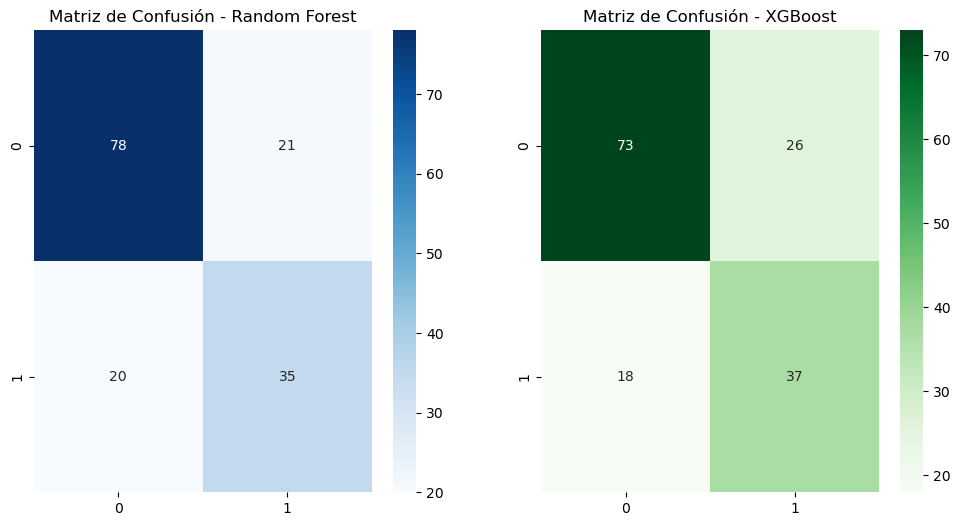

In [35]:
# Matriz de confusión
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - XGBoost')

plt.show()

Conclusión Visual
Random Forest es mejor identificando correctamente a quienes no tienen diabetes y comete menos errores al diagnosticar falsamente la enfermedad.
XGBoost es mejor para identificar a quienes sí tienen diabetes, reduciendo los casos en los que la enfermedad pasa desapercibida.
Elección del Modelo
Si es más importante evitar falsos positivos (diagnosticar diabetes en alguien que no la tiene), elige Random Forest.
Si es más importante evitar falsos negativos (no diagnosticar diabetes en alguien que la tiene), elige XGBoost.
Ambos modelos son útiles, pero su elección depende de las prioridades del sistema médico o del impacto de los errores en este contexto.